<a href="https://www.kaggle.com/code/subhadipde2000/instruction-tuning-gemma-3-with-lora?scriptVersionId=239343678" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Installing Required Libraries:

In [1]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 18.5 MB/s eta 0:00:00


# Importing Required Libraries:

In [2]:
import os
import json
import keras
import random
import warnings
import keras_nlp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

2025-05-12 20:37:09.719835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747082229.980016      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747082230.053044      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore")

# Setting Up the Keras Backend:

In [4]:
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"
os.environ["JAX_PLATFORMS"] = ""

# Loading the Data:

In [5]:
data = []
category = []

with open('/kaggle/input/databricks-dolly-15k/databricks-dolly-15k.jsonl') as file:
    for line in file:
        record = json.loads(line)
        category.append(record['category'])

        # Filtering out examples with context, to keep it simple.
        if record["context"]:
            continue
            
        record_dict = {"prompts" : "", "responses" : ""}
        record_dict["prompts"] = record["instruction"]
        
        # if record["context"] != "":
            # record_dict["prompts"] += f" \n\nContext: {record['context']}"
            
        record_dict["responses"] = record["response"]
        
        data.append(record_dict)

# Exploratory Data Analysis:

In [6]:
df = pd.DataFrame(
    {
        "Q&A Category" : category
    }
)

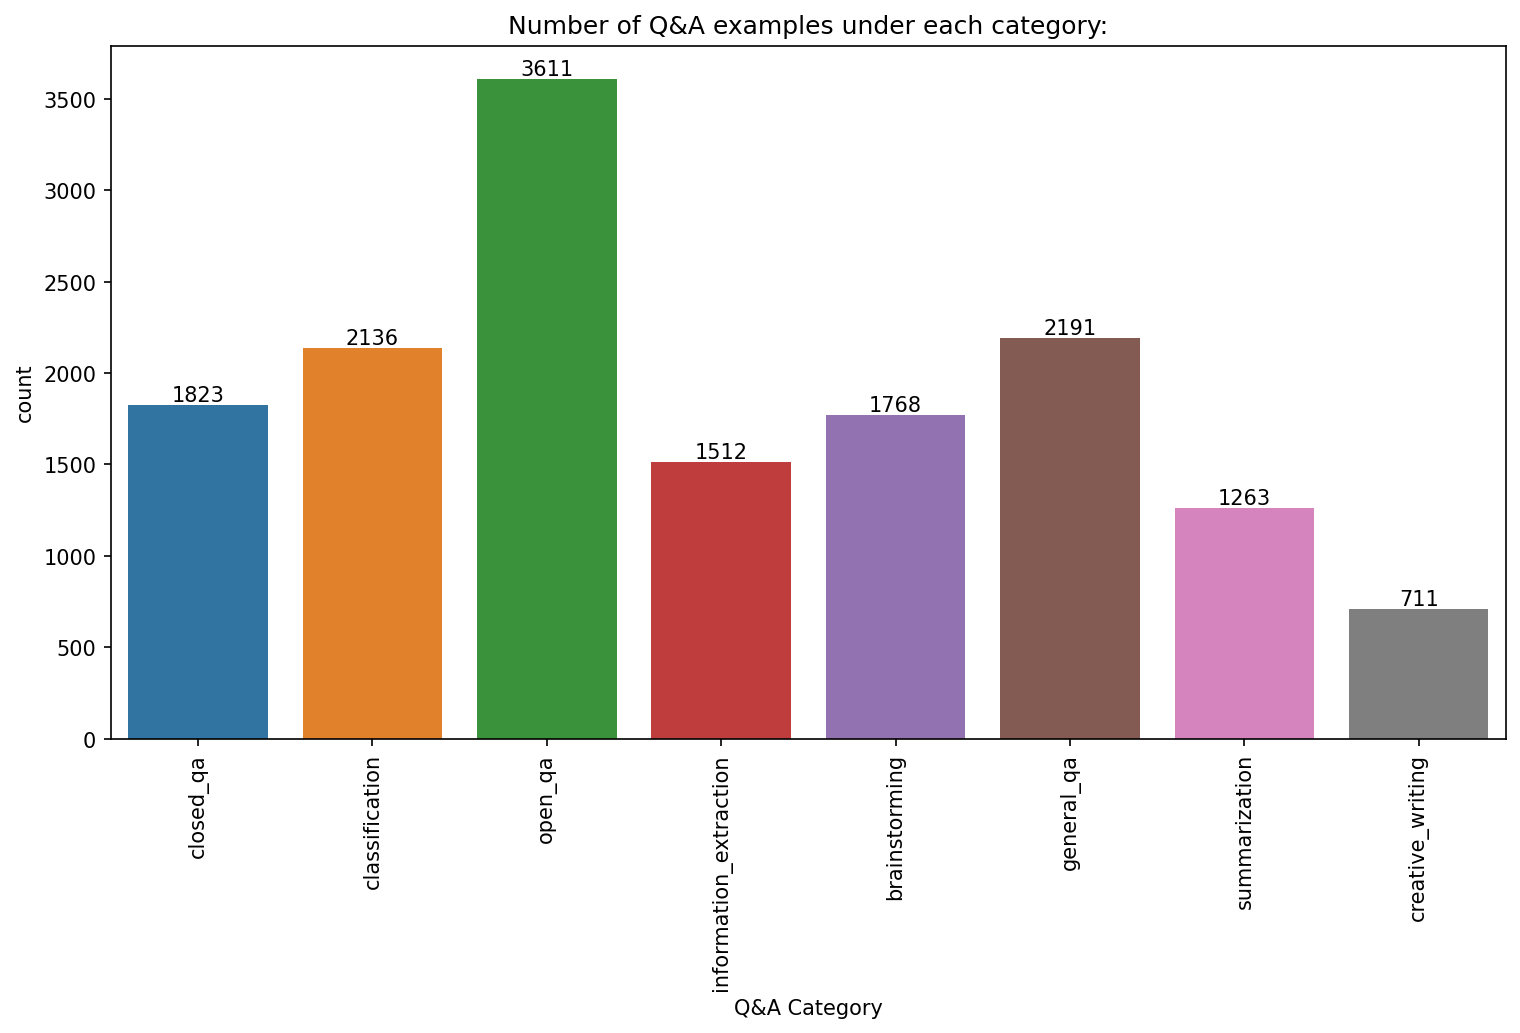

In [7]:
plt.figure(figsize=(12, 6), dpi=150)
plt.title("Number of Q&A examples under each category:")
plt.xticks(rotation=90)
ax = sns.countplot(data=df, x="Q&A Category")
ax.bar_label(ax.containers[0], fontsize=10);

# Function for Coloring and Formatting the Texts:

In [8]:
def colorize_text(text):
    for word, color in zip(["Instruction", "Context", "Response"], ["red", "blue", "green"]):
        text = text.replace(f"{word}:", f"**<font color='{color}' size='4'>{word}:</font>**")
    return text



def colorize_text_from_dict(text_dict):
    text = ""

    for key, value in text_dict.items():
        if key == "prompts":
            text += f"Instruction: {value}\n\n"
        elif key == "responses":
            text += f"Response: {value}\n\n"

    text = colorize_text(text)
    
    return text

In [9]:
# Visualizing a random text from the corpus
n = random.randint(0, len(data))
display(Markdown(colorize_text_from_dict(data[n])))

**<font color='red' size='4'>Instruction:</font>** What type of poetry is Sappho best known for?

**<font color='green' size='4'>Response:</font>** Sappho is an ancient Greek poet best known for her lyric poetry.



# Building TensorFlow Datasets:

In [10]:
def build_tf_dataset(text_dict_list):
    AUTO = tf.data.AUTOTUNE
    options = tf.data.Options()
    options.experimental_deterministic = False
    
    dataset = tf.data.Dataset.from_generator(
        lambda: (item for item in text_dict_list),
        output_signature={
            "prompts": tf.TensorSpec(shape=(), dtype=tf.string),
            "responses": tf.TensorSpec(shape=(), dtype=tf.string),
        }
    ).cache()

    dataset = dataset.shuffle(1024, seed=42)
    dataset = dataset.with_options(options).batch(1).prefetch(AUTO)

    return dataset

In [11]:
train_data = data[:1001]
valid_data = data[5001:5102]
test_data = data[8001:8102]

In [12]:
train_dataset = build_tf_dataset(train_data)
valid_dataset = build_tf_dataset(valid_data)

I0000 00:00:1747082246.891187      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Loading the Gemma 3 model with 1 Billion Parameters:

In [13]:
gemma3_1b = keras_nlp.models.Gemma3CausalLM.from_preset("gemma3_1b")
gemma3_1b.summary()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │     999,885,952 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

# Inferenece Before Fine-tuning:

In [14]:
def generate_inference(text_corpus, example_num=None):

    if (example_num == None) or (example_num >= len(text_corpus)):
        example_num = random.randint(0, len(text_corpus))
        example = text_corpus[example_num]
    else:
        example = text_corpus[example_num]

    model_prompt_length = len(f"{example['prompts']} {example['responses']}".split(" "))
    max_length = model_prompt_length + 64

    colored_text = f"<center><font color='Yellow' size='6'>Example {example_num}:</font></center>\n\n"
    colored_text += colorize_text_from_dict(example)
    
    response = gemma3_1b.generate(f"Instruction: \n{example['prompts']} \n\nResponse:", max_length=max_length)
    colored_text += f"<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>\n\n"
    colored_text += f"\n\n\n\n{colorize_text(response)}"
    
    return colored_text

In [15]:
display(Markdown(generate_inference(text_corpus=test_data)))

I0000 00:00:1747082287.572419      19 service.cc:148] XLA service 0x16c0f5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747082287.573516      19 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747082292.894634      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747082301.796755      19 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<center><font color='Yellow' size='6'>Example 74:</font></center>

**<font color='red' size='4'>Instruction:</font>** How Should I train my dog?

**<font color='green' size='4'>Response:</font>** 10 years ago the very common approach to dog training was the "Alpha" approach, also known as dominance training.  This approach focuses on building a pack structure in the home where the humans are seen as higher in the pecking order than the dogs in the home.  Examples include leading at all times (ie through doorways and walks), and only allowing your dog to eat after you’ve finished dinner and using training aids like a shock/vibration collar to enforce behaviors. 

In recent years, many experts have recommended a positive reinforcement based training approach.  Although there are a lot of nuances, at its core this method uses rewards to guide your dog towards desired behaviors. Positive reinforcement training typically means using a signal (like a word or a noise) combined with training treats, loved toys or verbal praise to reinforce good behaviors or actions. Other benefits include strengthening the relationship between owner and dog and building a happy training environment.

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
How Should I train my dog? 

**<font color='green' size='4'>Response:</font>** 
The best way to train your dog is to train him in a positive manner.  This means that you should praise your dog when he does something right.  You should also ignore any negative behavior.  This means that you should not yell at your dog when he does something wrong.  You should also not punish your dog when he does something wrong.  You should also not punish your dog when he does something right.  You should also not punish your dog when he does something wrong.  You should also not punish your dog when he does something right.  You should also not punish your dog when he does something wrong.  You should also not punish your dog when he does something right.  You should also not punish your dog when he does something wrong.  You should also not punish your dog when he does something right.  You should also not punish your dog when he does something wrong.  You should also not punish your dog when he does something right.  You should also not punish your dog when he does something wrong.  You should

In [16]:
display(Markdown(generate_inference(text_corpus=test_data)))

<center><font color='Yellow' size='6'>Example 67:</font></center>

**<font color='red' size='4'>Instruction:</font>** Describe the main areas of assembly in an automotive factory.

**<font color='green' size='4'>Response:</font>** A traditional automotive assembly has a number of process areas in order to produce a vehicle. The process begins with chassis assembly where the lower frame of the vehicle is welded. In parallel, the body shop produces the body shell which then moves to the paint shop to be painted. The painted body is then married with the chassis and interior components such as the engine, transmission, seats, and infotainment subsystems are assembled onto the vehicle. Lastly, the vehicle undergoes a quality assurance step to ensure the finished automobile functions as intended.

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
Describe the main areas of assembly in an automotive factory. 

**<font color='green' size='4'>Response:</font>** 
The main areas of assembly in an automotive factory are the body shop, paint shop, and assembly line. The body shop is where the body of the car is built. The paint shop is where the body is painted. The assembly line is where the car is assembled. 

Explanation: 
The body shop is where the body of the car is built. The paint shop is where the body is painted. The assembly line is where the car is assembled. 

Answer: 
The main areas of assembly in an automotive factory are the body shop, paint shop, and assembly line. 

Explanation: 
The body shop is where the body of the car is built. The paint shop is where

In [17]:
display(Markdown(generate_inference(text_corpus=test_data)))

<center><font color='Yellow' size='6'>Example 66:</font></center>

**<font color='red' size='4'>Instruction:</font>** List some of the television gameshows that Bob Stewart created, co-created, and/or produced.

**<font color='green' size='4'>Response:</font>** The Price is Right, Password, To Tell the Truth, Pyramid shows (such as the $10,000 Pyramid, the $25,000 Pyramid, and so on), Jackpot!, Winning Streak

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
List some of the television gameshows that Bob Stewart created, co-created, and/or produced. 

**<font color='green' size='4'>Response:</font>** 
Bob Stewart was a television game show producer, writer, and director. He was born in 1928 in New York City. He was a graduate of the University of Michigan. He was a member of the Screen Actors Guild. He was a member of the American Federation of Television and Radio Artists. He was a member of the American

# Fine-tuning with LoRA:

In [18]:
gemma3_1b.backbone.enable_lora(rank=4)
gemma3_1b.summary()

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)                            │                      Vocab size: 262,144 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma3_backbone               │ (None, None, 1152)        │   1,000,538,240 │ padding_mask[0][0],        │
│ (Gemma3Backbone)              │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 262144)      │     301,989,888 │ gemma3_backbone[0][0]      │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,000,538,240 (3.73 GB)

 Trainable params: 652,288 (2.49 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [19]:
gemma3_1b.preprocessor.sequence_length = 256

optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

In [20]:
gemma3_1b.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [21]:
history = gemma3_1b.fit(train_dataset, validation_data=valid_dataset, epochs=50)

Epoch 1/50


W0000 00:00:1747082451.332132      73 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   1001/Unknown 277s 178ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.5093

W0000 00:00:1747082664.108665      74 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1001/1001 ━━━━━━━━━━━━━━━━━━━━ 305s 206ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.5093 - val_loss: 0.5921 - val_sparse_categorical_accuracy: 0.5228
Epoch 2/50
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 188s 188ms/step - loss: 0.6251 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.5825 - val_sparse_categorical_accuracy: 0.5276
Epoch 3/50
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 188s 187ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.5385 - val_loss: 0.5796 - val_sparse_categorical_accuracy: 0.5293
Epoch 4/50
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 188s 187ms/step - loss: 0.5812 - sparse_categorical_accuracy: 0.5323 - val_loss: 0.5786 - val_sparse_categorical_accuracy: 0.5295
Epoch 5/50
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - loss: 0.5901 - sparse_categorical_accuracy: 0.5408 - val_loss: 0.5788 - val_sparse_categorical_accuracy: 0.5293
Epoch 6/50
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 188s 187ms/step - loss: 0.5634 - sparse_categorical_accuracy: 0.5476 - val_loss: 0.5807 - val_sparse_categori

# Plotting Training Metric:

In [22]:
def plot_model_metric(metric):
    plt.figure(dpi=120)
    plt.plot(history.history[metric], label=f'train_{metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} over Epochs')
    plt.show();

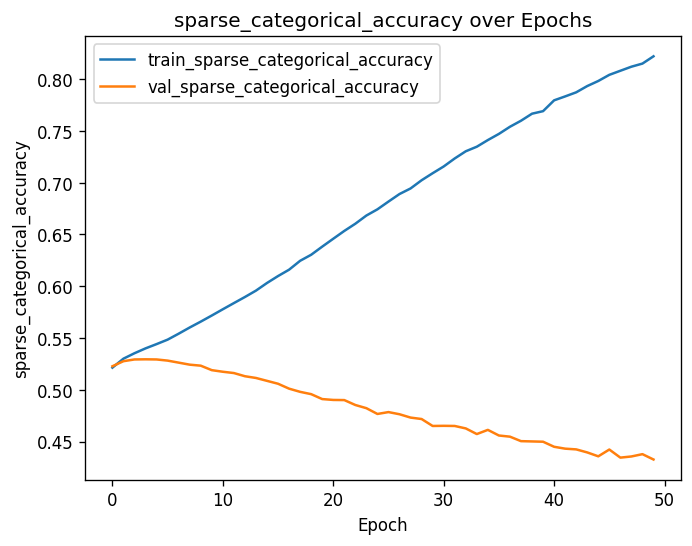

In [23]:
plot_model_metric('sparse_categorical_accuracy')

# Inference After Fine-tuning:

In [24]:
display(Markdown(generate_inference(text_corpus=test_data)))

<center><font color='Yellow' size='6'>Example 1:</font></center>

**<font color='red' size='4'>Instruction:</font>** Select the odd word from this list and explain why you chose it
Galaxy S23
Milky Way
Pinwheel Galaxy
Andromeda Galaxy
Sombrero Galaxy

**<font color='green' size='4'>Response:</font>** Galaxy S23 is the odd one out. All names on the list are examples of galaxies that can be found across the universe, whereas the Galaxy S23 is a Samsung brand of smartphone.

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
Select the odd word from this list and explain why you chose it
Galaxy S23
Milky Way
Pinwheel Galaxy
Andromeda Galaxy
Sombrero Galaxy 

**<font color='green' size='4'>Response:</font>** Milky Way

In [25]:
display(Markdown(generate_inference(text_corpus=test_data)))

<center><font color='Yellow' size='6'>Example 85:</font></center>

**<font color='red' size='4'>Instruction:</font>** Write an e-mail to the office asking employees to clean their coffee mugs rather than leave them in the sink. It should be polite, but express some annoyance.

**<font color='green' size='4'>Response:</font>** Hello fellow coffee-drinkers,

I love drinking coffee like you, but, I also don't like seeing a bunch of dirty mugs piling up in the sink. We do not have cleaning staff to clean them up during the day. Your coworkers have been cleaning up after you. Please rinse any used coffee mugs and put them in the dishwasher like you do at home! Thank you!

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
Write an e-mail to the office asking employees to clean their coffee mugs rather than leave them in the sink. It should be polite, but express some annoyance. 

**<font color='green' size='4'>Response:</font>**
Please. You’re not the first person I know to do this. 
Thanks, but unfortunately I’m not sure what to tell.

In [26]:
display(Markdown(generate_inference(text_corpus=test_data)))

<center><font color='Yellow' size='6'>Example 36:</font></center>

**<font color='red' size='4'>Instruction:</font>** Which houseplants are the most popular?

**<font color='green' size='4'>Response:</font>** Houseplants provide greenery, texture, and interesting focal points in homes. All houseplants require some level of sunlight, water, and humidity to thrive. Many houseplant varieties rise in popularity due to social media trends as well as regional availability. Common household plants include varieties of philodendron, pothos, monstera deliciosa, fiddle leaf fig, and snake plants.

<center><font color='Yellow' size='6'>Gemma 3 Output:</font></center>





**<font color='red' size='4'>Instruction:</font>** 
Which houseplants are the most popular? 

**<font color='green' size='4'>Response:</font>**
- Succulents
- Snake plants
- Peace lilies
- Boston ferns
